# Data wrangling project - Dog rating data set from Twitter

In [118]:
# import all necessary libraries
import pandas as pd
import requests
import tweepy
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

# Gather data

## 1. The WeRateDogs Twitter archive from csv file

In [3]:
Dogarchive=pd.read_csv('twitter-archive-enhanced.csv')
Dogarchive.head()
Dogarchive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

## 2. Programatic download of tsv data with Dog image urls

In [4]:
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)
folder_name='tweet_image'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
with open(os.path.join(folder_name,url.split('/')[-1]),mode='wb') as file:
    file.write(response.content)

In [5]:
# storing the tsv data into a dataframe
imagepred=pd.read_csv(os.path.join(folder_name,"image-predictions.tsv"),delimiter="\t")

## 2. Data from Twitter

In [6]:
consumer_key = 'qMvi7Z4iRPMGKYgkXrDVJdbL9'
consumer_secret = 'IXhEjTP8NXDkZzdAVjFSaPtRjZQdrtxaABuvMKO6hS4cAX7Jee'
access_token = '100096730-1QZhfMa4QD5060D5QVxiUH1bbUwu3isJJlL16izg'
access_secret = 'BGI9ulFajY8ej8Tm4cZP1yKluUDK62YbidNlBFaGxOmec'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,parser = tweepy.parsers.JSONParser(),wait_on_rate_limit = True,wait_on_rate_limit_notify = True)

In [7]:
tweet_id=Dogarchive['tweet_id']
list_of_tweets=[]
no_tweets_found=[]
for tweet in tweet_id:
    try:
        list_of_tweets.append(api.get_status(tweet))
    except Exception as e:
        no_tweets_found.append(tweet)

Rate limit reached. Sleeping for: 650
Rate limit reached. Sleeping for: 653


In [8]:
print("Number of tweets identified ",len(list_of_tweets))
print("Number of tweets not identified ",len(no_tweets_found))

Number of tweets identified  2329
Number of tweets not identified  27


In [9]:
list_of_tweets[0]

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]},


In [10]:
# store json data into text file
with open('tweet_json.txt',"w") as file:
    for tweet_data in list_of_tweets:
        data=json.dumps(tweet_data)
        file.write(data+"\n")

In [11]:
# Create a dataframe from the tweet data that we just retrieved.
tweet_data = []
with open('tweet_json.txt') as json_file:
    for json_obj in json_file:
        tweet_shortdata_dict = {}
        tweet_alldata_dict = json.loads(json_obj)

        # Get all of the data we're interested in
        tweet_shortdata_dict['tweet_id'] = tweet_alldata_dict['id']
        tweet_shortdata_dict['retweet_count'] = tweet_alldata_dict['retweet_count']
        tweet_shortdata_dict['favorite_count'] = tweet_alldata_dict['favorite_count']
        whole_tweet = tweet_alldata_dict['text']
        tweet_shortdata_dict["short_url"] = whole_tweet[whole_tweet.find('https'):]
        tweet_shortdata_dict['followers_count'] = tweet_alldata_dict['user']['followers_count']
        tweet_shortdata_dict['friends_count'] = tweet_alldata_dict['user']['friends_count']
        whole_source = tweet_alldata_dict['source']
        tweet_shortdata_dict['only_device'] = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        tweet_shortdata_dict['retweeted_status'] = tweet_alldata_dict.get('retweeted_status', 'Original tweet')
        if tweet_shortdata_dict['retweeted_status']!="Original tweet":
            tweet_shortdata_dict['retweeted_status']="Retweet"
        # Append it to the data gathering list
        tweet_data.append(tweet_shortdata_dict)

# Create a dataframe from the data
tweet_data_df = pd.DataFrame(tweet_data)
tweet_data_df.head()

,tweet_id,retweet_count,favorite_count,short_url,followers_count,friends_count,only_device,retweeted_status
0,892420643555336193,7613,35897,https://t.co/MgUWQ76dJU,8811018,17,Twitter for iPhone,Original tweet
1,892177421306343426,5638,30970,https://t.co/aQFSeaCu9L,8811018,17,Twitter for iPhone,Original tweet
2,891815181378084864,3730,23307,https://t.co/r0YlrsGCgy,8811018,17,Twitter for iPhone,Original tweet
3,891689557279858688,7785,39183,https://t.co/tD36da7qLQ,8811018,17,Twitter for iPhone,Original tweet
4,891327558926688256,8385,37440,https://t.co/0g0KMIVXZ3,8811018,17,Twitter for iPhone,Original tweet


In [12]:
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2329 non-null   int64 
 1   retweet_count     2329 non-null   int64 
 2   favorite_count    2329 non-null   int64 
 3   short_url         2329 non-null   object
 4   followers_count   2329 non-null   int64 
 5   friends_count     2329 non-null   int64 
 6   only_device       2329 non-null   object
 7   retweeted_status  2329 non-null   object
dtypes: int64(5), object(3)
memory usage: 145.7+ KB


# Assessing data

## Manual assessment

### Each dataframe is displayed in the Jupyter Notebook for visual assessment purposes.

In [13]:
Dogarchive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [14]:
imagepred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [15]:
tweet_data_df

,tweet_id,retweet_count,favorite_count,short_url,followers_count,friends_count,only_device,retweeted_status
0,892420643555336193,7613,35897,https://t.co/MgUWQ76dJU,8811018,17,Twitter for iPhone,Original tweet
1,892177421306343426,5638,30970,https://t.co/aQFSeaCu9L,8811018,17,Twitter for iPhone,Original tweet
2,891815181378084864,3730,23307,https://t.co/r0YlrsGCgy,8811018,17,Twitter for iPhone,Original tweet
3,891689557279858688,7785,39183,https://t.co/tD36da7qLQ,8811018,17,Twitter for iPhone,Original tweet
4,891327558926688256,8385,37440,https://t.co/0g0KMIVXZ3,8811018,17,Twitter for iPhone,Original tweet
...,...,...,...,...,...,...,...,...
2324,666049248165822465,40,96,https://t.co/4B7cOc1EDq,8810993,17,Twitter for iPhone,Original tweet
2325,666044226329800704,130,269,https://t.co/DWnyCjf2mx,8810993,17,Twitter for iPhone,Original tweet
2326,666033412701032449,41,111,https://t.co/y671yMhoiR,8810993,17,Twitter for iPhone,Original tweet
2327,666029285002620928,42,120,https://t.co/r7mOb2m0UI,8810993,17,Twitter for iPhone,Original tweet


## Programmatic assessment¶

### Assess the data using panda functions

In [16]:
Dogarchive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [17]:
sum(Dogarchive['tweet_id'].duplicated())

0

In [18]:
numerators=Dogarchive.rating_numerator.unique()
Dogarchive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [19]:
#print whole text in order to verify numerators
indexes=[]
for j,i in enumerate(numerators):
    indexes.append(Dogarchive[i == Dogarchive['rating_numerator']].index.values[0])
    print(j+1,Dogarchive['rating_numerator'][indexes[j]],Dogarchive['text'][indexes[j]],"\n")

1 13 This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU 

2 12 This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB 

3 14 This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A 

4 5 This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948 

5 17 @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s 

6 11 Please don't send in photos without dogs in them. We're not @porch_rates. Insubordinate and churlish. Pretty good porch tho 11/10 https://t.co/HauE8M3Bu4 

7 10 @ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs 

8 420 @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research 


> some of the numerators seems to be fractional due to averaging of multiple dogs

In [20]:
# fractional ratings
with pd.option_context('max_colwidth', 150):
    display(Dogarchive[Dogarchive['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://...,27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


In [21]:
denominators=Dogarchive.rating_denominator.unique()

In [85]:
#print whole text in order to verify rating_denominator
indexes=[]
for j,i in enumerate(denominators):
    indexes.append(Dogarchive[i == Dogarchive['rating_denominator']].index.values[0])
    print(Dogarchive['tweet_id'][indexes[j]],Dogarchive['rating_numerator'][indexes[j]],Dogarchive['rating_denominator'][indexes[j]],Dogarchive['text'][indexes[j]])

892420643555336193 13 10 This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
835246439529840640 960 0 @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
832088576586297345 11 15 @docmisterio account started on 11/15/15
820690176645140481 84 70 The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
810984652412424192 24 7 Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
775096608509886464 9 11 RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
758467244762497024 165 150 Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
731156023742988288 204 170 Say hello to this unbelievably well behaved squad of doggos.

> some denomenators are to be corrected manually

In [ ]:
| Twitter ID         | Old Rating numerator | Old Rating denomenator | New Rating numerator | New Rating denomenator |
|--------------------|----------------------|------------------------|----------------------|------------------------|
| 835246439529840640 | 960                  | 0                      | 13                   | 10                     |
| 832088576586297345 | 11                   | 15                     | NaN                  | NaN                    |
| 810984652412424192 | 24                   | 7                      | NaN                  | NaN                    |
| 775096608509886464 | 9                    | 11                     | 14                   | 10                     |
| 722974582966214656 | 4                    | 20                     | 13                   | 10                     |
| 716439118184652801 | 50                   | 50                     | 11                   | 10                     |
| 666287406224695296 | 1                    | 2                      | 9                    | 10                     |

> The ratings with denomenator more than 10 are for multiple dogs and therefore we need to programmatically convert the scale to 10

In [23]:
imagepred.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
363,672877615439593473,https://pbs.twimg.com/media/CVaKn75XAAEU09u.jpg,1,Chihuahua,0.412362,True,beagle,0.068066,True,borzoi,0.045071,True
1447,776088319444877312,https://pbs.twimg.com/media/CsU4NKkW8AUI5eG.jpg,3,web_site,0.999916,False,pug,0.000077,True,menu,0.000002,False
1004,708845821941387268,https://pbs.twimg.com/media/CdZTgynWwAATZcx.jpg,1,schipperke,0.745640,True,kelpie,0.167853,True,Boston_bull,0.014763,True
990,707995814724026368,https://pbs.twimg.com/media/CdNOb17WwAA5z4A.jpg,1,agama,0.172087,False,Gila_monster,0.126978,False,lumbermill,0.050400,False
1929,858471635011153920,https://pbs.twimg.com/media/C-nnZBdXkAAB-wg.jpg,1,Pembroke,0.987407,True,Cardigan,0.008723,True,basenji,0.003424,True


In [24]:
imagepred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
sum(imagepred.tweet_id.duplicated()),sum(imagepred.jpg_url.duplicated())

(0, 66)

In [26]:
pd.concat(g for _, g in imagepred.groupby("jpg_url") if len(g) > 1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
480,675354435921575936,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1641,807106840509214720,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
1864,842892208864923648,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
1691,815966073409433600,https://pbs.twimg.com/ext_tw_video_thumb/81596...,1,Tibetan_mastiff,0.506312,True,Tibetan_terrier,0.295690,True,otterhound,0.036251,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2051,887473957103951883,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True
1033,711694788429553666,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False


In [27]:
print(imagepred.p1_dog.value_counts())
print(imagepred.p2_dog.value_counts())
print(imagepred.p3_dog.value_counts())

True     1532
False     543
Name: p1_dog, dtype: int64
True     1553
False     522
Name: p2_dog, dtype: int64
True     1499
False     576
Name: p3_dog, dtype: int64


In [28]:
imagepred.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [84]:
tweet_data_df.sample(10)

,tweet_id,retweet_count,favorite_count,short_url,followers_count,friends_count,only_device,retweeted_status
98,872820683541237760,3390,13792,https://t.co/M15eX8HhsR,8811018,17,Twitter for iPhone,Original tweet
559,800855607700029440,1631,0,https://t.co/pnUF69K4xk,8811017,17,Twitter for iPhone,Retweet
437,818588835076603904,6177,0,https://t.co/nBJ5RE4yHb,8811016,17,Twitter for iPhone,Retweet
2195,668466899341221888,482,849,https://t.co/YOHe6lf09m,8810993,17,Twitter for iPhone,Original tweet
532,805207613751304193,1743,7927,https://t.co/lHy4Xbyhd9,8811017,17,Twitter for iPhone,Original tweet
747,777684233540206592,2949,11271,https://t.co/SuXcI9B7pQ,8811016,17,Twitter for iPhone,Original tweet
1161,718540630683709445,998,2417,https://t.co/zSbyvm62xZ,8810982,17,Twitter for iPhone,Original tweet
1887,674330906434379776,72,544,7,8810994,17,Twitter for iPhone,Original tweet
2165,668932921458302977,54,248,https://t.co/rcrKkL7eB6,8810993,17,Twitter for iPhone,Original tweet
914,753039830821511168,20749,36955,https://t.co/dsv4xAtfv7,8810983,17,Vine - Make a Scene,Original tweet


In [30]:
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2329 non-null   int64 
 1   retweet_count     2329 non-null   int64 
 2   favorite_count    2329 non-null   int64 
 3   short_url         2329 non-null   object
 4   followers_count   2329 non-null   int64 
 5   friends_count     2329 non-null   int64 
 6   only_device       2329 non-null   object
 7   retweeted_status  2329 non-null   object
dtypes: int64(5), object(3)
memory usage: 145.7+ KB


In [31]:
tweet_data_df.retweeted_status.value_counts()

Original tweet    2166
Retweet            163
Name: retweeted_status, dtype: int64

In [32]:
tweet_data_df.only_device.value_counts()

Twitter for iPhone     2195
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                10
Name: only_device, dtype: int64

## Quality

### Completeness, validity, accuracy, consistency (content issues)

#### twitter_archive
    1. The dataset contains not only original ratings, but also retweet ratings.
    2. Delete columns like doggo, floofer, pupper and puppo that won't be used for analysis
    3. Erroneous datatypes (doggo, floofer, pupper and puppo columns)
    4. Incorrect number rating numerator
    5. Correct denominators other than 10. 
    6. Separate timestamp into day - month - year (3 columns)
    
       
#### image_prediction
    7. Drop duplicates in the jpg_url column
    8. Create 1 column for image prediction and 1 column for confidence level
    
#### tweet_json
    9. Keep original tweets only

## Tidiness
    1. Change tweet_id to type int64 in order to merge with the other 2 tables
    2. All tables should be part of one dataset

## Cleaning Data

In [92]:
Dogarchive_clean = Dogarchive.copy()
imagepred_clean = imagepred.copy()
tweet_data_df_clean = tweet_data_df.copy()

### Quality related cleaning

 **1. The dataset contains not only original ratings, but also retweet ratings.**

Define : Delete retweets by filtering the null values in retweeted_status_user_id column

In [93]:
#CODE: 
Dogarchive_clean = Dogarchive_clean[pd.isnull(Dogarchive_clean['retweeted_status_user_id'])]

#TEST
print(sum(Dogarchive_clean.retweeted_status_user_id.value_counts()))

0


In [94]:
Dogarchive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

**2. Delete columns like doggo, floofer, pupper and puppo that won't be used for analysis**

In [95]:
Dogarchive_clean.drop(columns=['source','in_reply_to_status_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id','expanded_urls'],inplace=True)

In [96]:
#Test
list(Dogarchive_clean)

['tweet_id',
 'timestamp',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

**3. Erroneous datatypes (doggo, floofer, pupper and puppo columns)**

Define: Melt the doggo, floofer, pupper and puppo columns to dogs and dogs_group column. 

In [97]:
#CODE: Melt the doggo, floofer, pupper and puppo columns to dogs and dogs_group column
Dogarchive_clean = pd.melt(Dogarchive_clean, id_vars=['tweet_id',                                          
                                                                'timestamp',
                                                                'text',
                                                                'rating_numerator',
                                                                'rating_denominator',
                                                                'name'],
                               var_name='dogs', value_name='dogs_group')

#CODE: drop dogs
Dogarchive_clean = Dogarchive_clean.drop('dogs', axis=1)

#CODE: Sort by dogs_stage then drop duplicated based on tweet_id except the last occurrence
Dogarchive_clean = Dogarchive_clean.sort_values('dogs_group').drop_duplicates(subset='tweet_id',
                                                                                        keep='last')

In [98]:
#TEST
Dogarchive_clean['dogs_group'].value_counts()

None       1831
pupper      234
doggo        75
puppo        25
floofer      10
Name: dogs_group, dtype: int64

In [99]:
Dogarchive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dogs_group
2095,667443425659232256,2015-11-19 20:44:47 +0000,Exotic dog here. Long neck. Weird paws. Obsess...,6,10,None,None
2094,667453023279554560,2015-11-19 21:22:56 +0000,Meet Cupcake. I would do unspeakable things fo...,11,10,Cupcake,None
2093,667455448082227200,2015-11-19 21:32:34 +0000,This is Reese and Twips. Reese protects Twips....,7,10,Reese,None
2092,667470559035432960,2015-11-19 22:32:36 +0000,This is a northern Wahoo named Kohl. He runs t...,11,10,a,None
2091,667491009379606528,2015-11-19 23:53:52 +0000,Two dogs in this one. Both are rare Jujitsu Py...,7,10,None,None


**4. Correct Incorrect number rating numerator**

    a. Fractional ratings

In [100]:
# Find indexes of text with fractional ratings
with pd.option_context('max_colwidth', 200):
    display(Dogarchive_clean[Dogarchive_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
42,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
3685,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
3708,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10
2733,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
4967,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10


In [101]:
#CODE

#First change numerator and denominators type int to float to allow decimals 
Dogarchive_clean[['rating_numerator', 'rating_denominator']] = Dogarchive_clean[['rating_numerator','rating_denominator']].astype(float)

#Update numerators

Dogarchive_clean.loc[Dogarchive_clean.index==42, 'rating_numerator'] = 13.5
Dogarchive_clean.loc[Dogarchive_clean.index==2733, 'rating_numerator'] = 9.75
Dogarchive_clean.loc[Dogarchive_clean.index==4967, 'rating_numerator'] = 11.27
Dogarchive_clean.loc[Dogarchive_clean.index==3685, 'rating_numerator'] = 9.5
Dogarchive_clean.loc[Dogarchive_clean.index==3708, 'rating_numerator'] = 11.26
Dogarchive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 2095 to 7298
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2175 non-null   int64  
 1   timestamp           2175 non-null   object 
 2   text                2175 non-null   object 
 3   rating_numerator    2175 non-null   float64
 4   rating_denominator  2175 non-null   float64
 5   name                2175 non-null   object 
 6   dogs_group          2175 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 135.9+ KB


In [102]:
#Test
with pd.option_context('max_colwidth', 200):
    display(Dogarchive_clean[Dogarchive_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
42,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10.0
3685,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,9.50,10.0
3708,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0
2733,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10.0
4967,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0


**5. Dogarchive- Correct the denominators**

a. Manual

Define - some of the ratings are mistyped or gathered wrong. Need to be manually corrected

| Twitter ID         | Old Rating numerator | Old Rating denomenator | New Rating numerator | New Rating denomenator |
|--------------------|----------------------|------------------------|----------------------|------------------------|
| 835246439529840640 | 960                  | 0                      | 13                   | 10                     |
| 832088576586297345 | 11                   | 15                     | NaN                  | NaN                    |
| 810984652412424192 | 24                   | 7                      | NaN                  | NaN                    |
| 775096608509886464 | 9                    | 11                     | 14                   | 10                     |
| 722974582966214656 | 4                    | 20                     | 13                   | 10                     |
| 716439118184652801 | 50                   | 50                     | 11                   | 10                     |
| 666287406224695296 | 1                    | 2                      | 9                    | 10                     |

In [103]:
#CODE: Update both numerators and denominators
Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 835246439529840640), 'rating_numerator'] = 13
Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 835246439529840640), 'rating_denominator'] = 10

Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 775096608509886464), 'rating_numerator'] = 14
Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 775096608509886464), 'rating_denominator'] = 10

Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 666287406224695296), 'rating_numerator'] = 9
Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 666287406224695296), 'rating_denominator'] = 10

Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 722974582966214656), 'rating_numerator'] = 13
Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 722974582966214656), 'rating_denominator'] = 10

Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 716439118184652801), 'rating_numerator'] = 11
Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 716439118184652801), 'rating_denominator'] = 10

Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 666287406224695296), 'rating_numerator'] = 9
Dogarchive_clean.loc[(Dogarchive_clean.tweet_id == 666287406224695296), 'rating_denominator'] = 10


#CODE: Delete five tweets with no actual ratings
Dogarchive_clean = Dogarchive_clean[Dogarchive_clean['tweet_id'] != 832088576586297345]
Dogarchive_clean = Dogarchive_clean[Dogarchive_clean['tweet_id'] != 810984652412424192]

#TEST: Left only the group dogs for programatically clean
with pd.option_context('max_colwidth', 200):
    display(Dogarchive_clean[Dogarchive_clean['rating_denominator'] != 10][['tweet_id','text',
                                                                                      'rating_numerator',
                                                                                      'rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
3429,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40.0
3631,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0
3630,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0
3659,682808988178739200,"I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible",20.0,16.0
3658,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7.0,11.0
3594,686035780142297088,"Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating",4.0,20.0
3250,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
3225,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0
3270,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0
3347,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0


b. Programatically <br><br>
Define - These tweets above with denominator not equal to 10 are for multiple dogs. So, we get the ratings out of 10 by dividing numerator and denominator and multiplying by 10

In [104]:
#CODE: Create a new column with rating in float type to avoid converting all int column to float
Dogarchive_clean['rating_numerator'] = 10 * Dogarchive_clean['rating_numerator'] / Dogarchive_clean['rating_denominator']
Dogarchive_clean['rating_denominator']= 10

#TEST
Dogarchive_clean.loc[3429,:]

tweet_id                                             697463031882764288
timestamp                                     2016-02-10 16:51:59 +0000
text                  Happy Wednesday here's a bucket of pups. 44/40...
rating_numerator                                                     11
rating_denominator                                                   10
name                                                               None
dogs_group                                                         None
Name: 3429, dtype: object

**6. Twitter_archive - Separate timestamp into day - month - year (3 columns)**

Define : First convert timestamp to datetime. Then extract year, month and day to new columns. Finally drop timestamp column.

In [105]:
Dogarchive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dogs_group
2095,667443425659232256,2015-11-19 20:44:47 +0000,Exotic dog here. Long neck. Weird paws. Obsess...,6.0,10,None,None
2094,667453023279554560,2015-11-19 21:22:56 +0000,Meet Cupcake. I would do unspeakable things fo...,11.0,10,Cupcake,None
2093,667455448082227200,2015-11-19 21:32:34 +0000,This is Reese and Twips. Reese protects Twips....,7.0,10,Reese,None
2092,667470559035432960,2015-11-19 22:32:36 +0000,This is a northern Wahoo named Kohl. He runs t...,11.0,10,a,None
2091,667491009379606528,2015-11-19 23:53:52 +0000,Two dogs in this one. Both are rare Jujitsu Py...,7.0,10,None,None


In [106]:
#CODE: convert timestamp to datetime
Dogarchive_clean['timestamp'] = pd.to_datetime(Dogarchive_clean['timestamp'])

#Test
Dogarchive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 2095 to 7298
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2173 non-null   int64              
 1   timestamp           2173 non-null   datetime64[ns, UTC]
 2   text                2173 non-null   object             
 3   rating_numerator    2173 non-null   float64            
 4   rating_denominator  2173 non-null   int64              
 5   name                2173 non-null   object             
 6   dogs_group          2173 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(3)
memory usage: 215.8+ KB


**7. Imagepred dataframe - Drop duplicates in the jpg_url column**

In [107]:
# Define - Delete the 66 duplicates in the jpg url column

#CODE: 
imagepred_clean = imagepred_clean.drop_duplicates(subset=['jpg_url'], keep='last')

#TEST
sum(imagepred_clean['jpg_url'].duplicated())

0

**8. Image_prediction** - Create 1 column for image prediction and 1 column for confidence level

Create a function where I keep the first true prediction along the confidence level as new columns.

In [108]:
#CODE: the first true prediction (p1, p2 or p3) will be store in these lists
dog_type = []
confidence_list = []

#create a function with nested if to capture the dog type and confidence level
# from the first 'true' prediction
def image(imagepred_clean):
    if imagepred_clean['p1_dog'] == True:
        dog_type.append(imagepred_clean['p1'])
        confidence_list.append(imagepred_clean['p1_conf'])
    elif imagepred_clean['p2_dog'] == True:
        dog_type.append(imagepred_clean['p2'])
        confidence_list.append(imagepred_clean['p2_conf'])
    elif imagepred_clean['p3_dog'] == True:
        dog_type.append(imagepred_clean['p3'])
        confidence_list.append(imagepred_clean['p3_conf'])
    else:
        dog_type.append('Error')
        confidence_list.append('Error')

#series objects having index the image_prediction_clean column.        
imagepred_clean.apply(image, axis=1)

#create new columns
imagepred_clean['dog_type'] = dog_type
imagepred_clean['confidence_list'] = confidence_list

#drop rows that has prediction_list 'error'
imagepred_clean = imagepred_clean[imagepred_clean['dog_type'] != 'Error']

#Delete columns
imagepred_clean = imagepred_clean.drop(['img_num', 'p1', 
                                                      'p1_conf', 'p1_dog', 
                                                      'p2', 'p2_conf', 
                                                      'p2_dog', 'p3', 
                                                      'p3_conf', 
                                                      'p3_dog'], 1)

#TEST
list(imagepred_clean)

['tweet_id', 'jpg_url', 'dog_type', 'confidence_list']

In [109]:
imagepred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         1691 non-null   int64 
 1   jpg_url          1691 non-null   object
 2   dog_type         1691 non-null   object
 3   confidence_list  1691 non-null   object
dtypes: int64(1), object(3)
memory usage: 66.1+ KB


**9. Tweet_json - keep only original tweets**

Define - delete all the retweets

In [110]:
#CODE:
tweet_data_df_clean = tweet_data_df_clean[tweet_data_df_clean['retweeted_status'] == 'Original tweet']

#TEST
tweet_data_df_clean['retweeted_status'].value_counts()

Original tweet    2166
Name: retweeted_status, dtype: int64

In [111]:
#Drop the retweeted status column
tweet_data_df_clean.drop('retweeted_status',axis=1,inplace=True)

### Tidiness related cleaning

**12. Tidiness - All tables should be part of one dataset**

In [140]:
#CODE: create a new dataframe that merge twitter_archive_clean and 
#image_prediction_clean
df_twitter= pd.merge(Dogarchive_clean, 
                      imagepred_clean, 
                      how = 'left', on = ['tweet_id'])

#keep rows that have picture (jpg_url)
df_twitter = df_twitter[df_twitter['jpg_url'].notnull()]

#TEST
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1625 entries, 1 to 2172
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1625 non-null   int64              
 1   timestamp           1625 non-null   datetime64[ns, UTC]
 2   text                1625 non-null   object             
 3   rating_numerator    1625 non-null   float64            
 4   rating_denominator  1625 non-null   int64              
 5   name                1625 non-null   object             
 6   dogs_group          1625 non-null   object             
 7   jpg_url             1625 non-null   object             
 8   dog_type            1625 non-null   object             
 9   confidence_list     1625 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(6)
memory usage: 139.6+ KB


In [141]:
#CODE: create a new dataframe that merge df_twitter and tweet_json_clean
df_twitter1 = pd.merge(df_twitter, tweet_data_df_clean, 
                      how = 'left', on = ['tweet_id'])

#TEST
df_twitter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1625 entries, 0 to 1624
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1625 non-null   int64              
 1   timestamp           1625 non-null   datetime64[ns, UTC]
 2   text                1625 non-null   object             
 3   rating_numerator    1625 non-null   float64            
 4   rating_denominator  1625 non-null   int64              
 5   name                1625 non-null   object             
 6   dogs_group          1625 non-null   object             
 7   jpg_url             1625 non-null   object             
 8   dog_type            1625 non-null   object             
 9   confidence_list     1625 non-null   object             
 10  retweet_count       1617 non-null   float64            
 11  favorite_count      1617 non-null   float64            
 12  short_url           1617 non-null 

In [114]:
df_twitter['rating_numerator'].value_counts()

12.00     404
10.00     354
11.00     342
13.00     212
9.00      133
8.00       68
7.00       31
14.00      22
6.00       16
5.00       13
4.00        6
3.00        5
2.00        2
13.50       2
44.00       1
143.00      1
99.00       1
45.00       1
60.00       1
144.00      1
88.00       1
84.00       1
9.75        1
0.00        1
11.26       1
165.00      1
11.27       1
121.00      1
80.00       1
Name: rating_numerator, dtype: int64

<a id='storing'></a>
## Storing, Analyzing, and Visualizing Data

In [115]:
#Store the clean DataFrame in a CSV file
df_twitter1.to_csv('twitter_archive_cleaned.csv', 
                 index=False, encoding = 'utf-8')

In [116]:
df_twitter['dog_type'].value_counts()

golden_retriever        142
Labrador_retriever      103
Pembroke                 94
Chihuahua                87
pug                      60
                       ... 
EntleBucher               1
standard_schnauzer        1
silky_terrier             1
Bouvier_des_Flandres      1
clumber                   1
Name: dog_type, Length: 113, dtype: int64

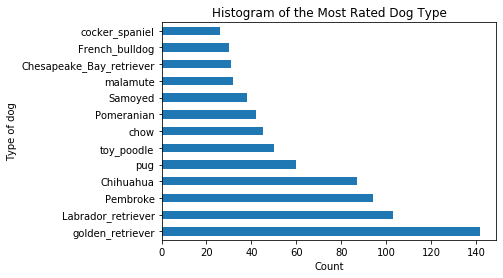

In [123]:
df_dog_type = df_twitter.groupby('dog_type').filter(lambda x: len(x) >= 25)

df_dog_type['dog_type'].value_counts().plot(kind = 'barh')
plt.title('Histogram of the Most Rated Dog Type')
plt.xlabel('Count')
plt.ylabel('Type of dog')

fig = plt.gcf() 
fig.savefig('output.png',bbox_inches='tight');

Insight two

In [127]:
df_dog_type_mean = df_twitter.groupby('dog_type').mean()

In [128]:
df_dog_type_mean.head()

,tweet_id,rating_numerator,rating_denominator,year,month,day,retweet_count_x,favorite_count_x,followers_count_x,friends_count_x,retweet_count_y,favorite_count_y,followers_count_y,friends_count_y
dog_type,,,,,,,,,,,,,,
Afghan_hound,8.095999e+17,8.000000,10.0,2016.500000,6.00,16.000000,3104.000000,11027.000000,8.811016e+06,17.0,3104.000000,11027.000000,8.811016e+06,17.0
Airedale,7.184489e+17,9.833333,10.0,2015.583333,8.75,15.916667,1211.083333,4783.750000,8.810996e+06,17.0,1211.083333,4783.750000,8.810996e+06,17.0
American_Staffordshire_terrier,7.597284e+17,10.312500,10.0,2016.187500,5.25,15.000000,1790.066667,7658.733333,8.811000e+06,17.0,1790.066667,7658.733333,8.811000e+06,17.0
Appenzeller,7.939334e+17,11.000000,10.0,2016.500000,4.50,18.500000,1251.000000,6635.500000,8.811001e+06,17.0,1251.000000,6635.500000,8.811001e+06,17.0
Australian_terrier,7.785921e+17,11.500000,10.0,2016.500000,3.50,7.000000,2706.000000,10118.500000,8.811000e+06,17.0,2706.000000,10118.500000,8.811000e+06,17.0


In [130]:
df_dog_type_sorted = df_dog_type_mean['rating_numerator'].sort_values()

df_dog_type_sorted

dog_type
Japanese_spaniel                5.000000
Afghan_hound                    8.000000
Walker_hound                    9.000000
Scotch_terrier                  9.000000
Tibetan_terrier                 9.250000
                                 ...    
Labrador_retriever             13.757282
chow                           14.311111
Great_Pyrenees                 14.666667
West_Highland_white_terrier    14.687500
soft-coated_wheaten_terrier    20.800000
Name: rating_numerator, Length: 113, dtype: float64

In [134]:
df_twitter.head()

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_group,year,month,day,jpg_url,...,short_url_x,followers_count_x,friends_count_x,only_device_x,retweet_count_y,favorite_count_y,short_url_y,followers_count_y,friends_count_y,only_device_y
0,667453023279554560,Meet Cupcake. I would do unspeakable things fo...,11.0,10.0,Cupcake,None,2015,11,19,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,...,https://t.co/6uLCWR9Efa,8810993.0,17.0,Twitter Web Client,84.0,297.0,https://t.co/6uLCWR9Efa,8810993.0,17.0,Twitter Web Client
1,667455448082227200,This is Reese and Twips. Reese protects Twips....,7.0,10.0,Reese,None,2015,11,19,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,...,https://t.co/uLzRi1drVK,8810993.0,17.0,Twitter Web Client,56.0,181.0,https://t.co/uLzRi1drVK,8810993.0,17.0,Twitter Web Client
2,667470559035432960,This is a northern Wahoo named Kohl. He runs t...,11.0,10.0,a,None,2015,11,19,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,...,https://t.co/J4vn2rOYFk,8810993.0,17.0,Twitter Web Client,89.0,243.0,https://t.co/J4vn2rOYFk,8810993.0,17.0,Twitter Web Client
3,667491009379606528,Two dogs in this one. Both are rare Jujitsu Py...,7.0,10.0,None,None,2015,11,19,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,...,https://t.co/ITxxcc4v9y,8810993.0,17.0,Twitter Web Client,210.0,499.0,https://t.co/ITxxcc4v9y,8810993.0,17.0,Twitter Web Client
4,667495797102141441,This is Philippe from Soviet Russia. Commandin...,9.0,10.0,Philippe,None,2015,11,20,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,...,https://t.co/5NhPV8E45i,8810993.0,17.0,Twitter Web Client,249.0,496.0,https://t.co/5NhPV8E45i,8810993.0,17.0,Twitter Web Client


In [143]:
print(df_twitter1.loc[df_twitter1.dog_type == 'Japanese_spaniel', 'short_url']) 

710    https://t.co/IoLRvF0Kak
Name: short_url, dtype: object


In [136]:
df_twitter[df_twitter['dog_type'] == 'golden_retriever']

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_group,year,month,day,jpg_url,...,short_url_x,followers_count_x,friends_count_x,only_device_x,retweet_count_y,favorite_count_y,short_url_y,followers_count_y,friends_count_y,only_device_y
8,667530908589760512,Meet Naphaniel. He doesn't necessarily enjoy h...,10.0,10.0,Naphaniel,None,2015,11,20,https://pbs.twimg.com/media/CUOL0uGUkAAx7yh.jpg,...,https://t.co/xoRWyQTcmy,8810993.0,17.0,Twitter Web Client,224.0,444.0,https://t.co/xoRWyQTcmy,8810993.0,17.0,Twitter Web Client
30,667044094246576128,12/10 gimme now https://t.co/QZAnwgnOMB,12.0,10.0,None,None,2015,11,18,https://pbs.twimg.com/media/CUHREBXXAAE6A9b.jpg,...,https://t.co/QZAnwgnOMB,8810993.0,17.0,Twitter for iPhone,46.0,175.0,https://t.co/QZAnwgnOMB,8810993.0,17.0,Twitter for iPhone
37,667160273090932737,This is Bradlay. He is a Ronaldinho Matsuyama ...,11.0,10.0,Bradlay,None,2015,11,19,https://pbs.twimg.com/media/CUI6uuaW4AAvCIs.jpg,...,https://t.co/DKhgkMx4N1,8810993.0,17.0,Twitter for iPhone,59.0,243.0,https://t.co/DKhgkMx4N1,8810993.0,17.0,Twitter for iPhone
43,667182792070062081,This is Timison. He just told an awful joke bu...,10.0,10.0,Timison,None,2015,11,19,https://pbs.twimg.com/media/CUJPNjOWsAAZRqP.jpg,...,https://t.co/s2yYuHabWl,8810993.0,17.0,Twitter for iPhone,5773.0,13543.0,https://t.co/s2yYuHabWl,8810993.0,17.0,Twitter for iPhone
46,667211855547486208,This is Genevieve. She is a golden retriever c...,9.0,10.0,Genevieve,None,2015,11,19,https://pbs.twimg.com/media/CUJppKJWoAA75NP.jpg,...,https://t.co/azEoGqVonH,8810993.0,17.0,Twitter for iPhone,224.0,463.0,https://t.co/azEoGqVonH,8810993.0,17.0,Twitter for iPhone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,693262851218264065,I hope you guys enjoy this beautiful snowy pup...,11.0,10.0,None,pupper,2016,1,30,https://pbs.twimg.com/media/CZ724fDUYAAytS-.jpg,...,https://t.co/DYUsHtL2aR,8810984.0,17.0,Twitter for iPhone,490.0,2186.0,https://t.co/DYUsHtL2aR,8810984.0,17.0,Twitter for iPhone
1588,675740360753160193,Here's a pupper licking in slow motion. 12/10 ...,12.0,10.0,None,pupper,2015,12,12,https://pbs.twimg.com/ext_tw_video_thumb/67574...,...,https://t.co/AUJi8ujxw9,8810994.0,17.0,Twitter for iPhone,329.0,1129.0,https://t.co/AUJi8ujxw9,8810994.0,17.0,Twitter for iPhone
1598,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, L...",12.0,10.0,Maggie,pupper,2016,7,31,https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg,...,https://t.co/MYwR4DQKll,8811017.0,17.0,Twitter for iPhone,1899.0,5950.0,https://t.co/MYwR4DQKll,8811017.0,17.0,Twitter for iPhone
1615,859607811541651456,Sorry for the lack of posts today. I came home...,13.0,10.0,None,puppo,2017,5,3,https://pbs.twimg.com/media/C-3wvtxXcAUTuBE.jpg,...,https://t.co/GL6vzAbHrv,8811017.0,17.0,Twitter for iPhone,1472.0,17792.0,https://t.co/GL6vzAbHrv,8811017.0,17.0,Twitter for iPhone


## Insight three & visualization

In [151]:
df_dog_type_count = df_twitter.groupby('dog_type').count()
df_dog_type_count

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dogs_group,jpg_url,confidence_list
dog_type,,,,,,,,,
Afghan_hound,2,2,2,2,2,2,2,2,2
Airedale,12,12,12,12,12,12,12,12,12
American_Staffordshire_terrier,16,16,16,16,16,16,16,16,16
Appenzeller,2,2,2,2,2,2,2,2,2
Australian_terrier,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...
toy_poodle,50,50,50,50,50,50,50,50,50
toy_terrier,3,3,3,3,3,3,3,3,3
vizsla,13,13,13,13,13,13,13,13,13


In [152]:
dog_type_count = df_dog_type_count['rating_numerator']
dog_type_mean = df_dog_type_mean['rating_numerator']
dog_type_mean

dog_type
Afghan_hound                       8.000000
Airedale                           9.833333
American_Staffordshire_terrier    10.312500
Appenzeller                       11.000000
Australian_terrier                11.500000
                                    ...    
toy_poodle                        11.020000
toy_terrier                       10.333333
vizsla                            10.846154
whippet                           10.181818
wire-haired_fox_terrier           11.500000
Name: rating_numerator, Length: 113, dtype: float64

In [153]:
df = pd.DataFrame()
df['dog_type_count'] = dog_type_count
df['dog_type_mean'] = dog_type_mean
df

,dog_type_count,dog_type_mean
dog_type,,
Afghan_hound,2,8.000000
Airedale,12,9.833333
American_Staffordshire_terrier,16,10.312500
Appenzeller,2,11.000000
Australian_terrier,2,11.500000
...,...,...
toy_poodle,50,11.020000
toy_terrier,3,10.333333
vizsla,13,10.846154


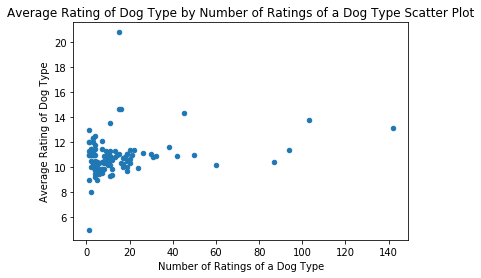

In [154]:
df.plot(x='dog_type_count', y='dog_type_mean', kind='scatter')
plt.xlabel('Number of Ratings of a Dog Type')
plt.ylabel('Average Rating of Dog Type')
plt.title('Average Rating of Dog Type by Number of Ratings of a Dog Type Scatter Plot')

fig = plt.gcf()
#plt.savefig('X:/' + newName + '.png', 
fig.savefig('Average rating vs number of ratings.png',bbox_inches='tight');

Insight four & visualization

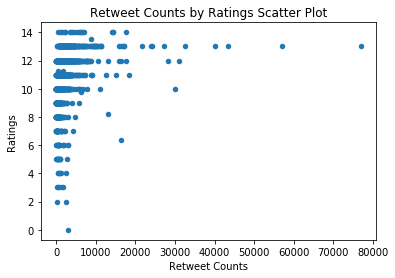

In [148]:
df_twitter1.plot(x='retweet_count', y='rating_numerator', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Ratings')
plt.title('Retweet Counts by Ratings Scatter Plot')

fig = plt.gcf()
fig.savefig('output3.png',bbox_inches='tight');